In [1]:
IMG_PATH = '../../datasets/alex/gold-std/neun'

import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, io, models, metrics
from glob import glob
from tifffile import imread, imwrite

np.random.seed(42)


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

>>> GPU activated? YES


In [2]:
X = sorted(glob(IMG_PATH + '/rawdata/*.tif'))
Y = sorted(glob(IMG_PATH + '/labels/*_labelimage.tif'))
# Y = sorted(glob('../../datasets/enhanced_label/*.tif'))
assert(len(X) == len(Y))

In [3]:
X = list(map(imread,X))
# X = [ x[1:2] for x in X ]
Y = list(map(imread,Y))

In [4]:
X_train = X[:-3]
Y_train = Y[:-3]
X_test = X[-3:]
Y_test = Y[-3:]

In [5]:
# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type='cyto2')


2024-09-25 21:42:34,774 [INFO] WRITING LOG OUTPUT TO /home/mac/wday/.cellpose/run.log
2024-09-25 21:42:34,775 [INFO] 
cellpose version: 	3.0.11 
platform:       	linux 
python version: 	3.8.19 
torch version:  	2.3.1
2024-09-25 21:42:34,779 [INFO] >> cyto2 << model set to be used
2024-09-25 21:42:34,782 [INFO] ** TORCH CUDA version installed and working. **
2024-09-25 21:42:34,784 [INFO] >>>> using GPU (CUDA)
2024-09-25 21:42:34,904 [INFO] >>>> loading model /home/mac/wday/.cellpose/models/cyto2torch_0
2024-09-25 21:42:35,052 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [6]:
# run model on images
masks = model.eval(X_test, channels=[2,1])[0]
masks_before = masks

# check performance using ground truth labels
ap = metrics.average_precision(Y_test, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2024-09-25 21:42:37,678 [INFO] 100%|##########| 3/3 [00:02<00:00,  1.15it/s]

>>> average precision at iou threshold 0.5 = 0.945


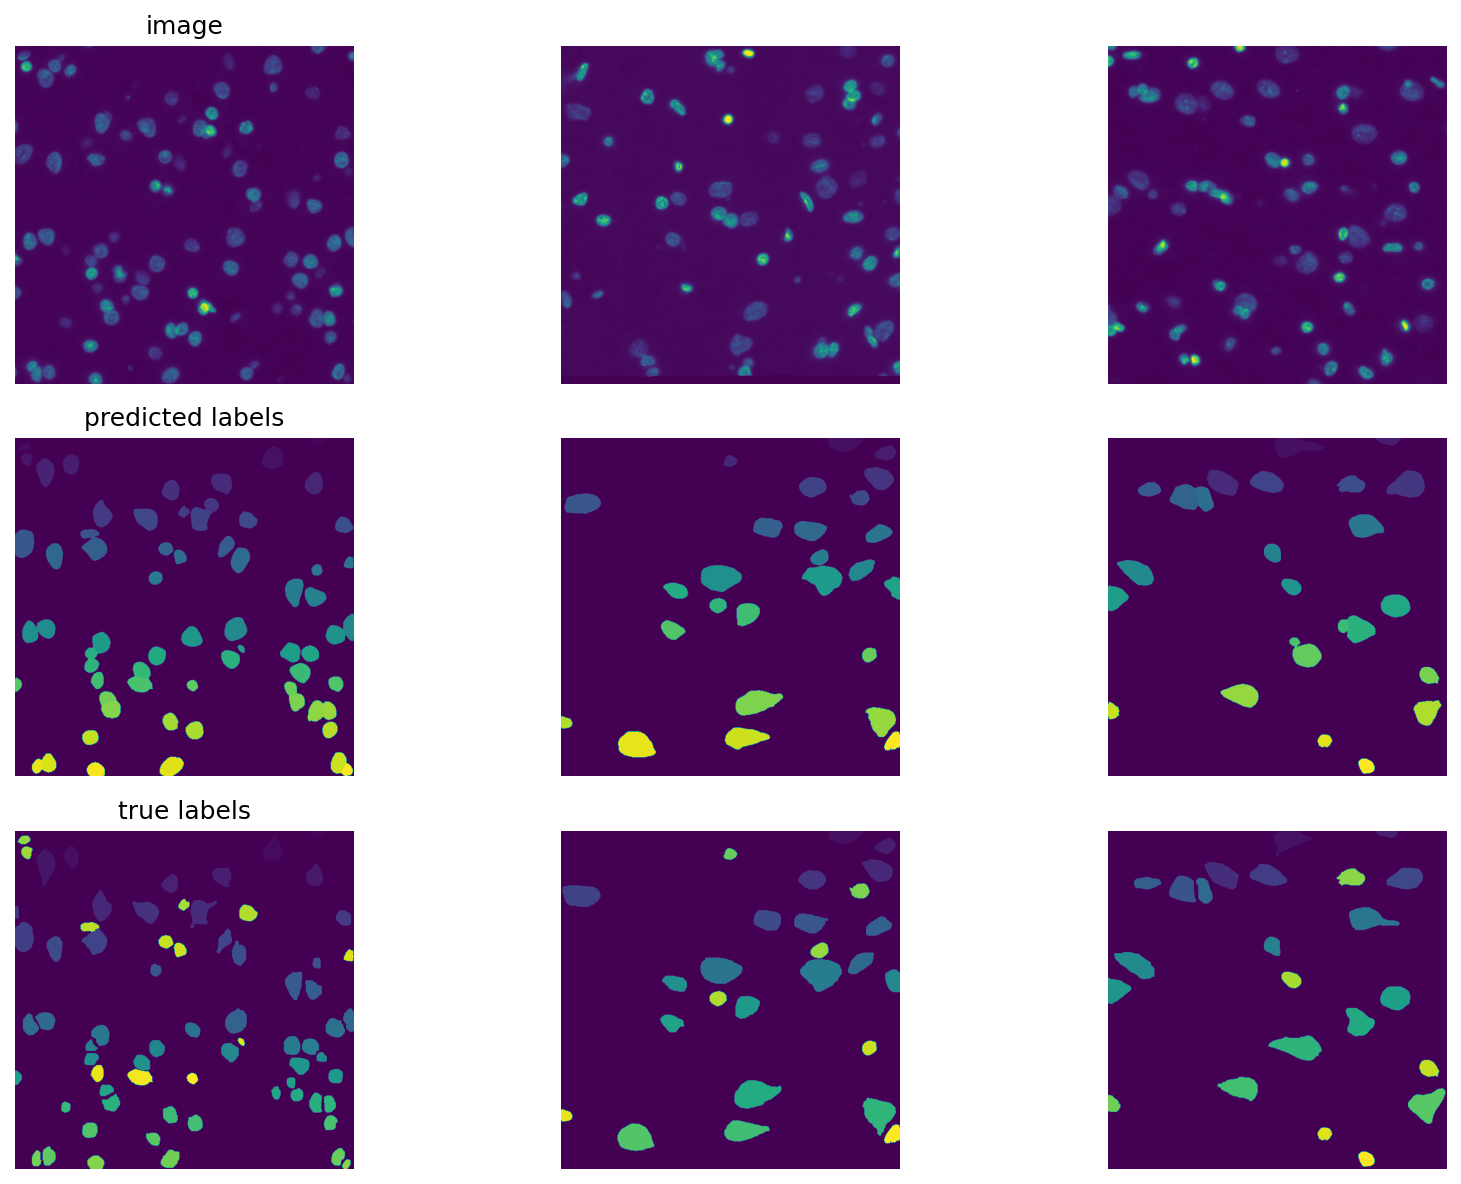

In [7]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(X_test):
    img = im.copy()
    plt.subplot(3,len(X_test), k+1)
    plt.imshow(img[0])
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(X_test), len(X_test) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(X_test), 2*len(X_test) + k+1)
    plt.imshow(Y_test[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

In [8]:
from cellpose import io, models, train
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d %H:%M:%S')

train_result = train.train_seg(model.net,
                            train_data=X_train, train_labels=Y_train,
                            normalize=True, channels=[2,1], 
                            test_data=X_test, test_labels=Y_test,
                            weight_decay=1e-4, SGD=True, learning_rate=0.01,
                            n_epochs=100, model_name=f"david_{timestamp}")

2024-09-25 21:42:40,068 [INFO] computing flows for labels


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

2024-09-25 21:42:41,601 [INFO] computing flows for labels



100%|██████████| 3/3 [00:00<00:00, 20.96it/s]

2024-09-25 21:42:41,753 [INFO] >>> computing diameters



100%|██████████| 3/3 [00:00<00:00, 684.86it/s]

2024-09-25 21:42:41,797 [INFO] >>> using channels [2, 1]
2024-09-25 21:42:41,798 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2024-09-25 21:42:42,194 [INFO] >>> n_epochs=100, n_train=20, n_test=3
2024-09-25 21:42:42,195 [INFO] >>> SGD, learning_rate=0.01000, weight_decay=0.00010, momentum=0.900
2024-09-25 21:42:44,211 [INFO] >>> saving model to /home/mac/wday/NeuroFluor-ML/notebooks/cellpose/models/david_2024-09-25 21:42:40
2024-09-25 21:42:44,950 [INFO] 0, train_loss=0.6385, test_loss=0.2181, LR=0.0000, time 0.74s
2024-09-25 21:42:46,952 [INFO] 5, train_loss=0.5128, test_loss=0.2051, LR=0.0056, time 2.74s
2024-09-25 21:42:48,912 [INFO] 10, train_loss=0.3352, test_loss=0.1727, LR=0.0100, time 4.70s
2024-09-25 21:42:52,960 [INFO] 20, train_loss=0.3138, test_loss=0.1575, LR=0.0100, time 8.75s
2024-09-25 21:42:56,967 [INFO] 30, train_loss=0.2631, test_loss=0.1496, LR=0.0100, time 12.76s
2024-09-25 21:43:00,938 [INFO] 40, train_loss=0.2712, test_loss=0.1455, LR=0.0100, time 16.73s
2024-09-25 21:43:04,927 [INFO] 50, train_loss=0.2441, test_loss=0.1405, LR=0.0100, time 20.72s
2024-09-25 21:43:08,661 [INFO] 60, trai

In [9]:
# run model on images
masks = model.eval(X_test, channels=[2, 1])[0]

# check performance using ground truth labels
ap = metrics.average_precision(Y_test, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2024-09-25 21:43:25,174 [INFO] 100%|##########| 3/3 [00:00<00:00,  3.90it/s]

>>> average precision at iou threshold 0.5 = 0.802


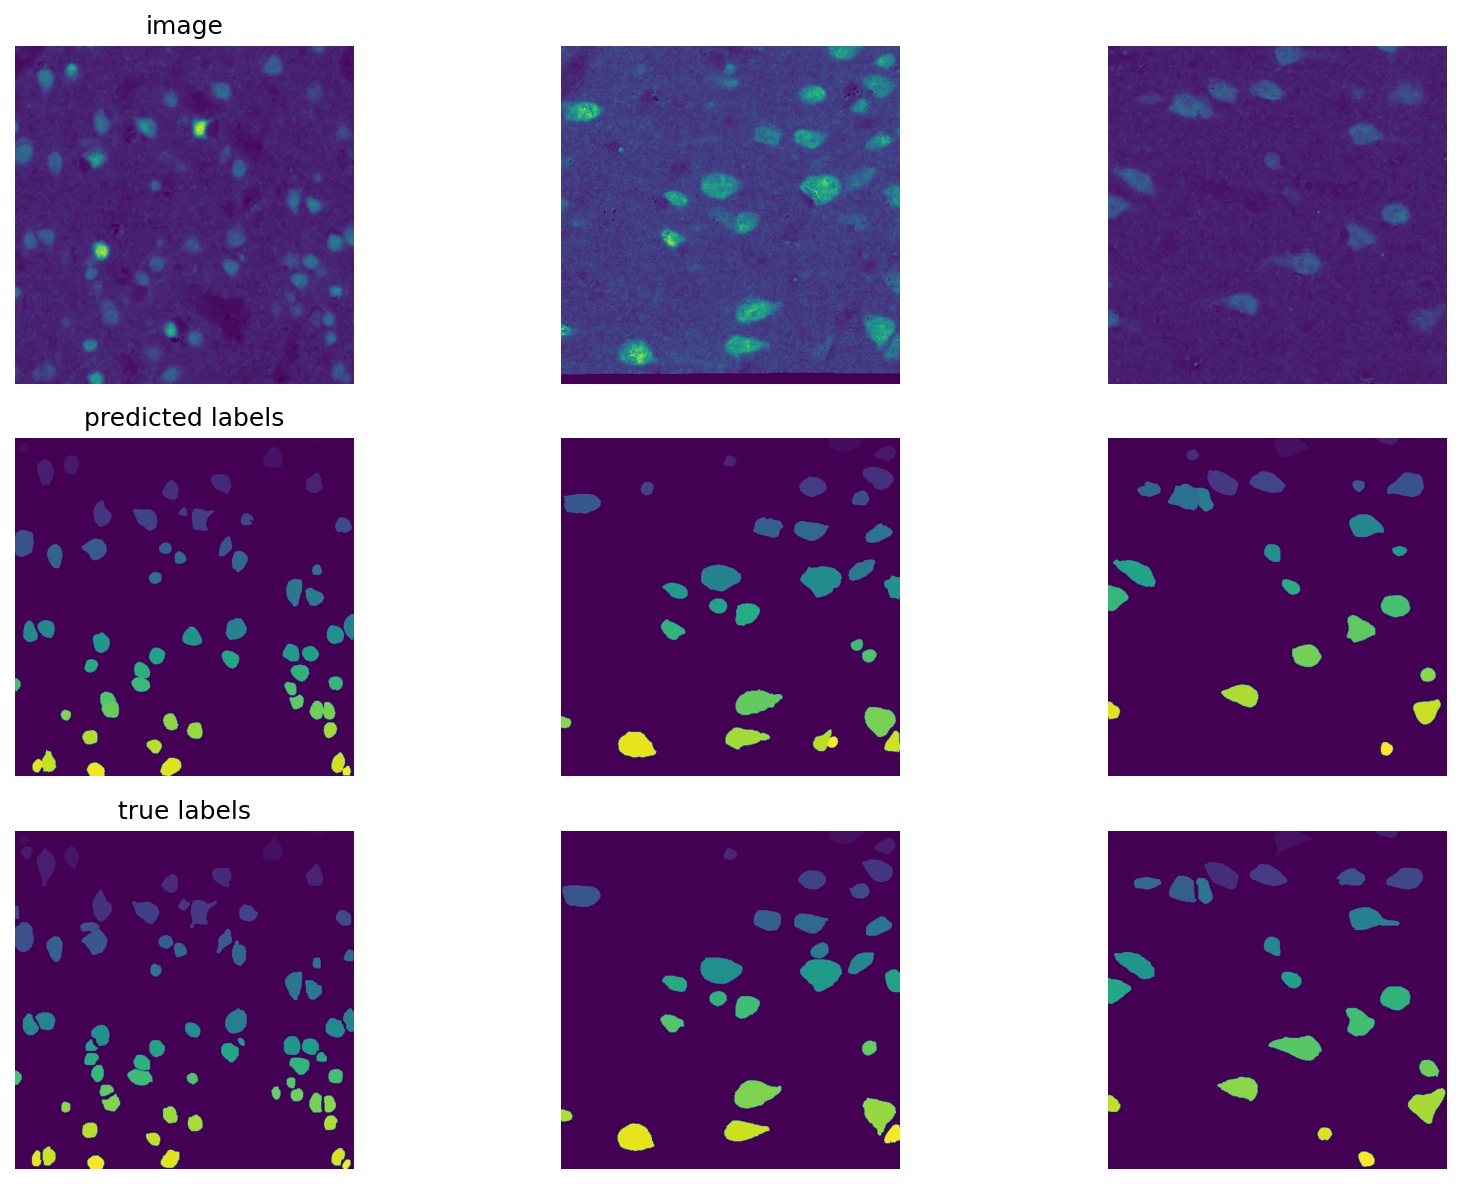

In [10]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(X_test):
    img = im.copy()
    plt.subplot(3,len(X_test), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img[1] #.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(X_test), len(X_test) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(X_test), 2*len(X_test) + k+1)
    plt.imshow(Y_test[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

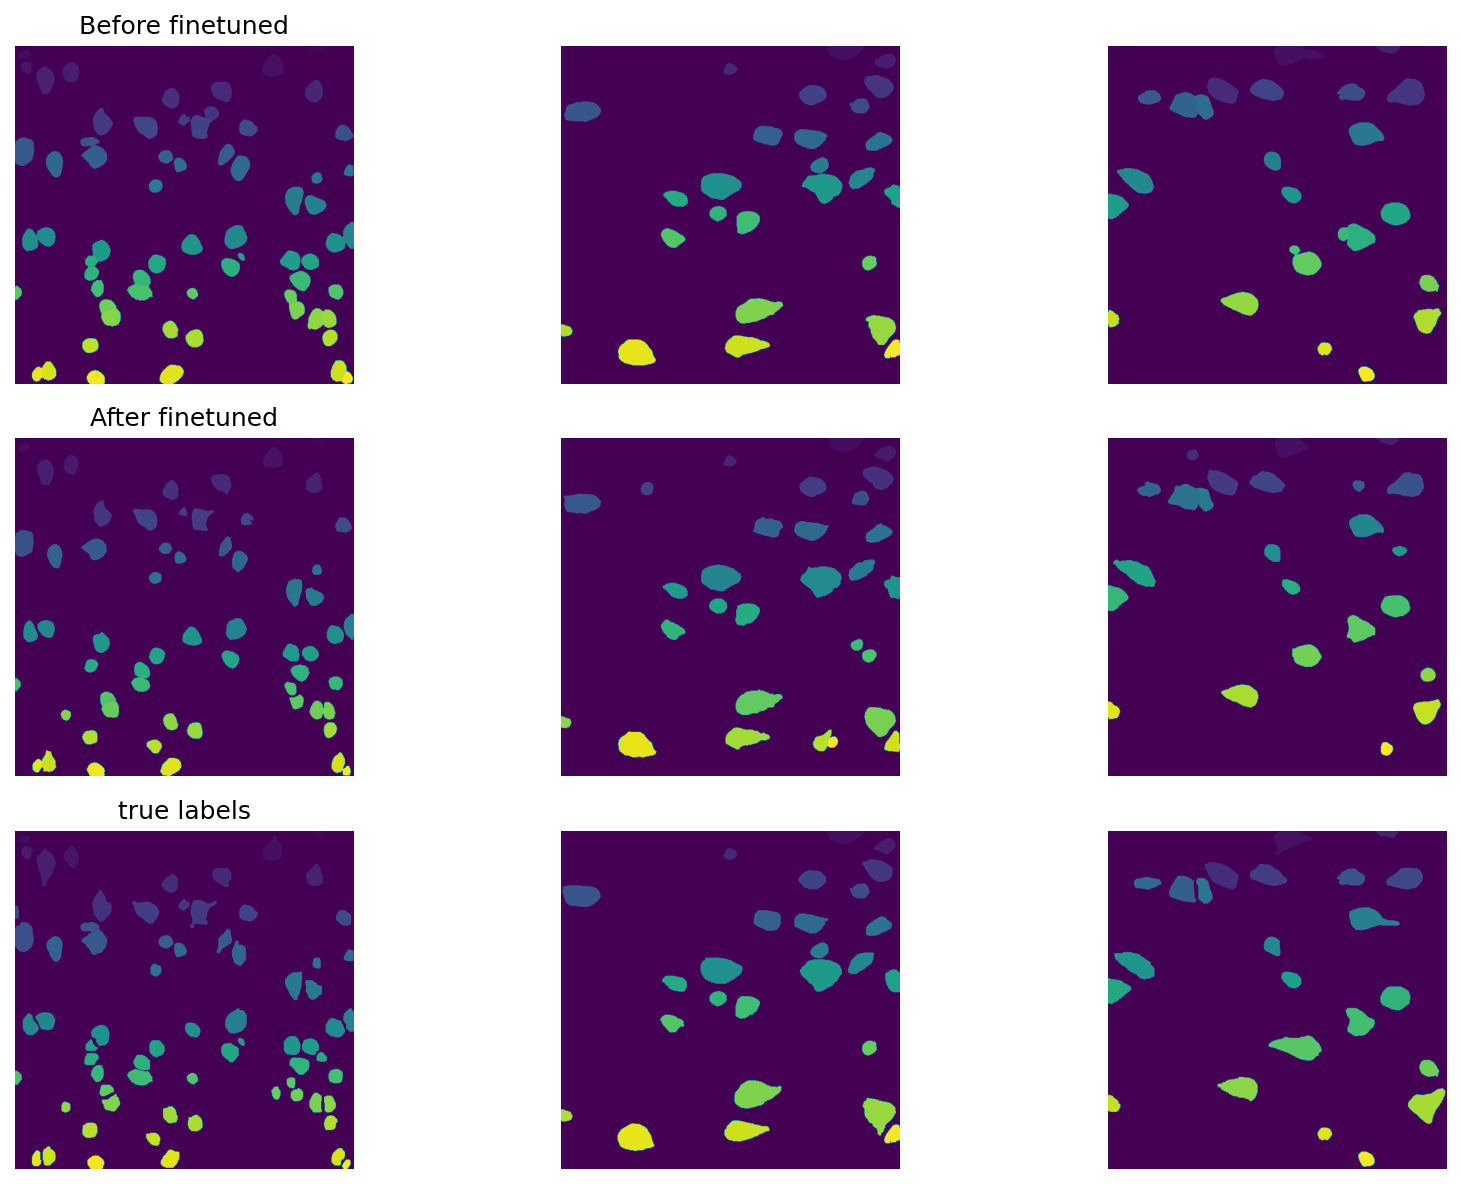

In [11]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(X_test):
    plt.subplot(3,len(X_test), k+1)
    plt.imshow(masks_before[k])
    plt.axis('off')
    if k==0:
        plt.title('Before finetuned')

    plt.subplot(3,len(X_test), len(X_test) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('After finetuned')

    plt.subplot(3,len(X_test), 2*len(X_test) + k+1)
    plt.imshow(Y_test[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

In [12]:
tdp_neun_paths = sorted(glob('../../datasets/S23010013/AFRemoved/NEUN_*'))
tdp_dapi_paths = sorted(glob('../../datasets/S23010013/RegisteredImages/S002/*_mono_dapi_reg_*'))
assert(len(tdp_neun_paths) == len(tdp_dapi_paths))

In [13]:
tdp_neun_image = list(map(imread,tdp_neun_paths))
tdp_dapi_iamge = list(map(imread,tdp_dapi_paths))

In [14]:
for i in range(len(tdp_neun_image)):
    print(tdp_neun_image[i].shape, tdp_dapi_iamge[i].shape)

(13053, 2050) (13053, 2050)
(2047, 13067) (2047, 13067)
(2043, 11220) (2043, 11220)
(9377, 2043) (9377, 2043)
(2042, 7547) (2042, 7547)
(2043, 9391) (2043, 9391)
(14896, 2046) (14896, 2046)
(2045, 11227) (2045, 11227)
(9384, 2048) (9384, 2048)
(2048, 11228) (2048, 11228)
(2042, 7556) (2042, 7556)
(11211, 2044) (11211, 2044)


In [15]:
tdp_masks = []
i = 0
for path, dapi, neun in zip(tdp_neun_paths, tdp_dapi_iamge, tdp_neun_image):
    x = np.stack([dapi, neun], axis=0)
    y = model.eval(x, channels=[2, 1])[0]
    tdp_masks.append(y)
    if i > 3:
        break
    i += 1
    # imwrite('outputs/david/' + path.split('/')[-1], y)

In [16]:
tdp_masks_old = []
for path in tdp_neun_paths:
    tdp_masks_old.append(imread('outputs/david/' + path.split('/')[-1]))

In [17]:
# alex_checkpoint = "./models/cellpose_residual_on_style_on_concatenation_off_2021083_1326-55_model-iba1_2021_08_03_20_27_30.138790"
# alex = models.CellposeModel(gpu=True, pretrained_model=alex_checkpoint)

# tdp_alex = []
# for path, dapi, neun in zip(tdp_neun_paths, tdp_dapi_iamge, tdp_neun_image):
#     x = np.stack([dapi, neun], axis=0)
#     y = alex.eval(x, channels=[2, 1])[0]
#     tdp_alex.append(y)
#     imwrite('outputs/alex/' + path.split('/')[-1], y)


tdp_alex = []
for path in tdp_neun_paths:
    tdp_alex.append(imread('outputs/alex/' + path.split('/')[-1]))


In [18]:
# cyto2 = models.CellposeModel(gpu=True, pretrained_model='cyto2')

# tdp_cyto2 = []
# for path, dapi, neun in zip(tdp_neun_paths, tdp_dapi_iamge, tdp_neun_image):
#     x = np.stack([dapi, neun], axis=0)
#     y = cyto2.eval(x, channels=[2, 1])[0]
#     tdp_cyto2.append(y)
#     imwrite('outputs/cyto2/' + path.split('/')[-1], y)


tdp_cyto2 = []
for path in tdp_neun_paths:
    tdp_cyto2.append(imread('outputs/cyto2/' + path.split('/')[-1]))

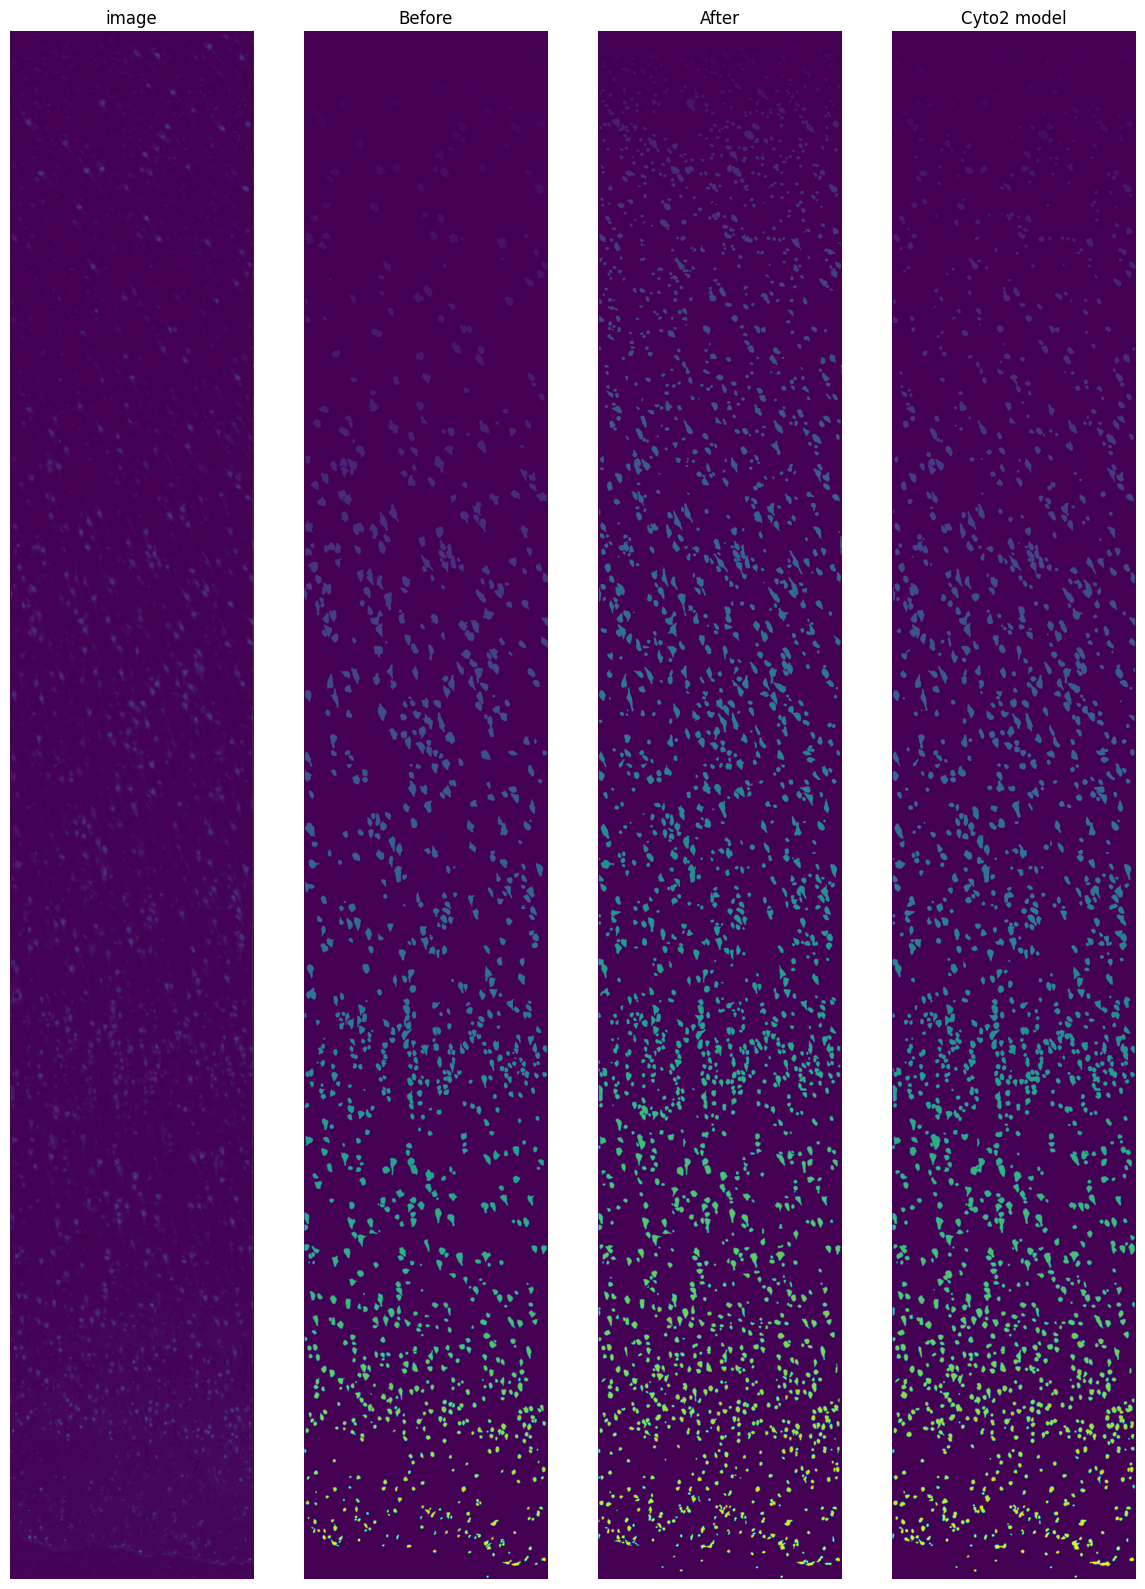

In [19]:
plt.figure(figsize=(12, 16))

i = 0

plt.subplot(1, 4, 1)
plt.imshow(tdp_neun_image[i])
plt.axis('off')
plt.title('image')

plt.subplot(1, 4, 2)
plt.imshow(tdp_masks_old[i])
plt.axis('off')
plt.title('Before') #Alex\'s model')

plt.subplot(1, 4, 3)
plt.imshow(tdp_masks[i])
plt.axis('off')
plt.title('After') #'David\'s model')

plt.subplot(1, 4, 4)
plt.imshow(tdp_cyto2[i])
plt.axis('off')
plt.title('Cyto2 model')

plt.tight_layout()

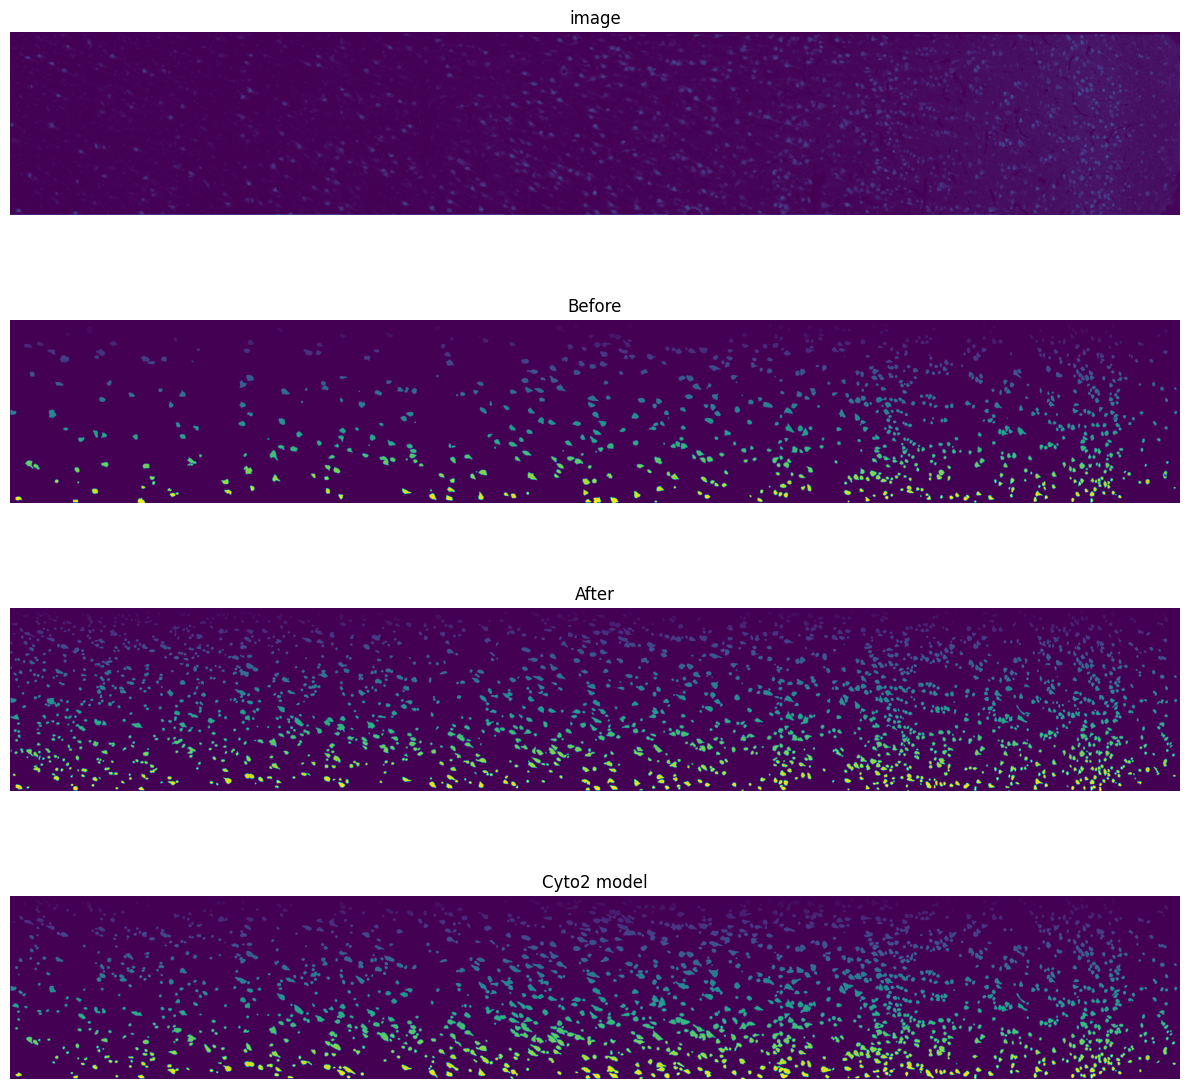

In [20]:
plt.figure(figsize=(12, 12))

i = 1

plt.subplot(4, 1, 1)
plt.imshow(tdp_neun_image[i])
plt.axis('off')
plt.title('image')

plt.subplot(4, 1, 2)
plt.imshow(tdp_masks_old[i])
plt.axis('off')
plt.title('Before') #Alex\'s model')

plt.subplot(4, 1, 3)
plt.imshow(tdp_masks[i])
plt.axis('off')
plt.title('After') #'David\'s model')

plt.subplot(4, 1, 4)
plt.imshow(tdp_cyto2[i])
plt.axis('off')
plt.title('Cyto2 model')

plt.tight_layout()

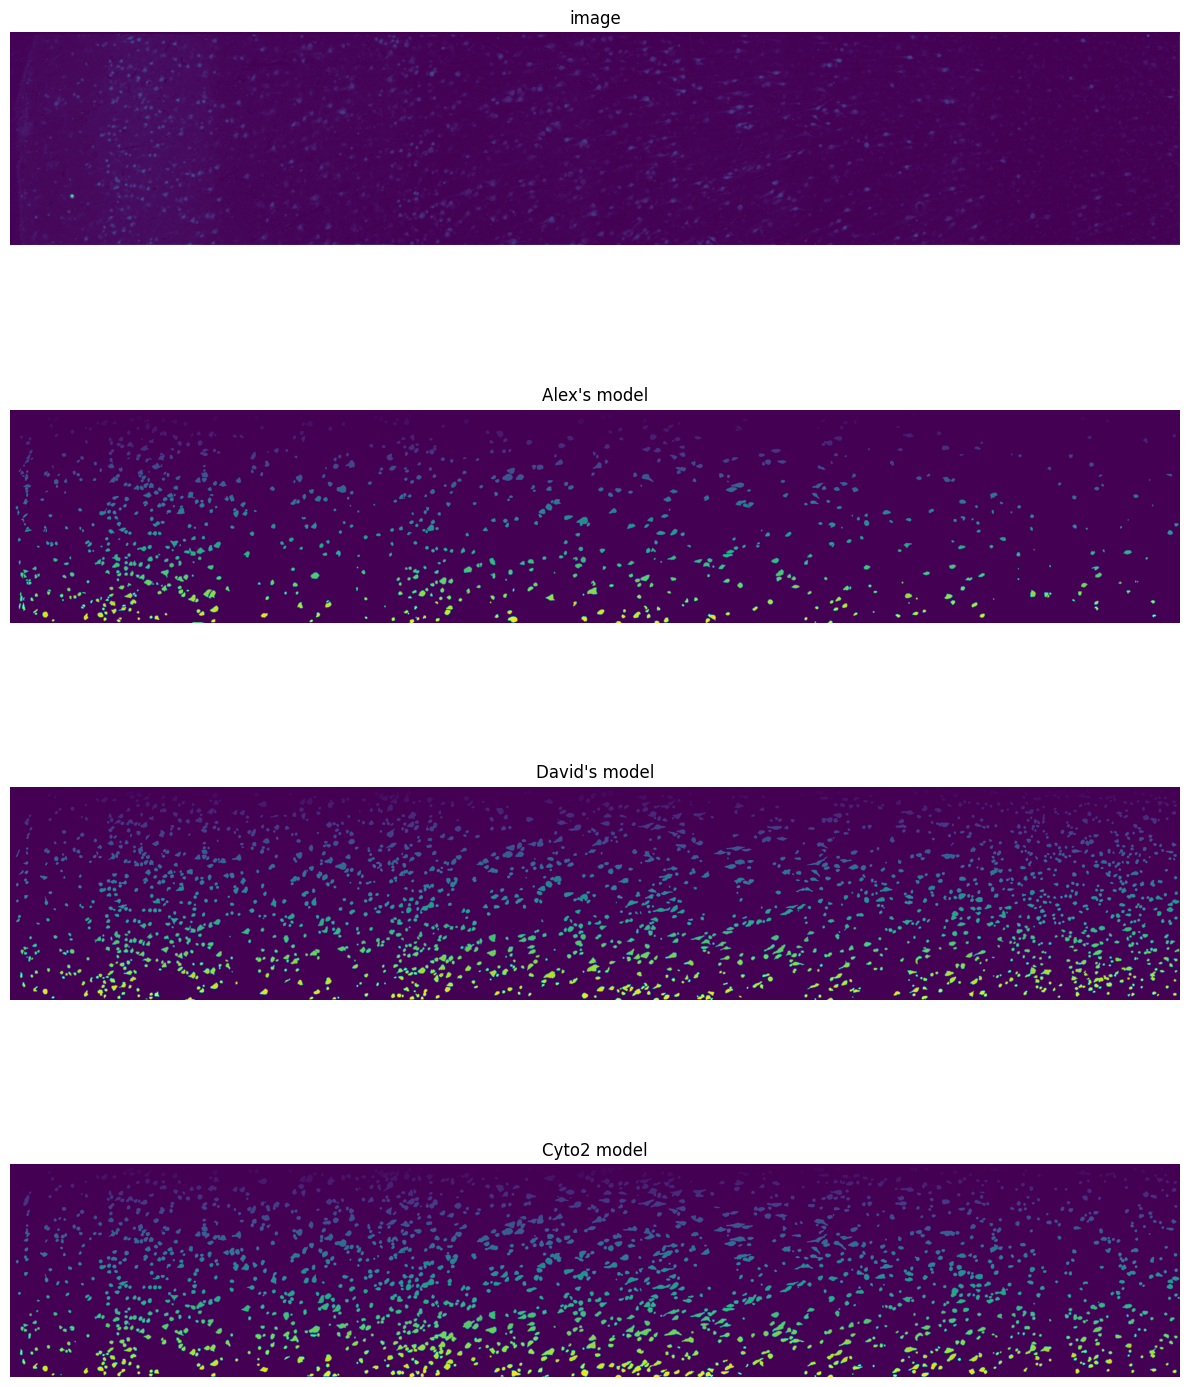

In [21]:
plt.figure(figsize=(12, 16))

i = 2

plt.subplot(4, 1, 1)
plt.imshow(tdp_neun_image[i])
plt.axis('off')
plt.title('image')

plt.subplot(4, 1, 2)
plt.imshow(tdp_alex[i])
plt.axis('off')
plt.title('Alex\'s model')

plt.subplot(4, 1, 3)
plt.imshow(tdp_masks[i])
plt.axis('off')
plt.title('David\'s model')

plt.subplot(4, 1, 4)
plt.imshow(tdp_cyto2[i])
plt.axis('off')
plt.title('Cyto2 model')

plt.tight_layout()